In [159]:
import numpy as np
import ast, dataIO, common_functions
from sklearn import cross_validation, linear_model, preprocessing, svm
from sklearn.grid_search import GridSearchCV
reload(dataIO)
reload(common_functions)

postures = {"left_hand":["4", "8", "11"], "right_hand":["1", "7", "10"], 
            "index_finger":["3", "5", "12"], "two_hand":["2", "6", "9"]}

locations = []
bod = []
targets_x = []
targets_y = []
y = []
touch_centers = []

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr

def process_twohand(userid, filenos, posture):
    
    centers = dataIO.get_key_centers()
    
    for fileno in filenos:
        filename = "/home/dimitar/Desktop/Python/experiment/results/"+str(userid)+"_"+fileno+"up.txt"
        with open(filename, "r") as f:
            lines = f.read().splitlines()
            lines = map(lambda x: x.split('\t'), lines[1:])
            for line in lines:
                letter = line[1]
                location = list(ast.literal_eval(line[3]))
                center = centers[letter]
                
                if not dataIO.iscorrect(location, center):
                    continue
                
                if line[0] == "left":
                    y.append(posture)
                else:
                    y.append(posture+1)
                
                touch_centers.append(center)
                targets_x.append(center[0]-location[0])
                targets_y.append(center[1]-location[1])                
                locations.append(location)
                bod.append(dataIO.createlist(line[-1]))
    

def process_posture(userid, filenos, posture): 
    
    centers = dataIO.get_key_centers()
    
    for fileno in filenos:
        filename = "/home/dimitar/Desktop/Python/experiment/results/"+str(userid)+"_"+fileno+"up.txt"
        with open(filename, "r") as f:
            lines = f.read().splitlines()
            lines = map(lambda x: x.split('\t'), lines[1:])
            for line in lines:
                letter = line[0]
                location = list(ast.literal_eval(line[2]))
                center = centers[letter]
                
                if not dataIO.iscorrect(location, center):
                    continue
                
                targets_x.append(center[0]-location[0])
                targets_y.append(center[1]-location[1])                
                touch_centers.append(center)
                locations.append(location)
                bod.append(dataIO.createlist(line[-1]))
                y.append(posture)
                

def read_data(userid):    
    keys = postures.keys()
    
    posture = 0
    for key in keys:
        filenos = postures[key]
        if key == "two_hand":
            process_twohand(userid, filenos, posture)
            posture += 2
        else:
            process_posture(userid, filenos, posture)
            posture += 1

read_data(17)

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

print("MSE on x before regression: %.2f"  % np.mean(targets_x ** 2))
print("MSE on y before regression: %.2f"  % np.mean(targets_y ** 2))
within_before = common_functions.circle_button_error(locations, touch_centers)

foldno = 1
se_x = []
se_y = []
within_after = []
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)

for train_index, test_index in kf:    
    points_train, points_test = locations[train_index], locations[test_index]
    bod_train, bod_test = bod[train_index], bod[test_index]
    t_x_train, t_x_test = targets_x[train_index], targets_x[test_index]
    t_y_train, t_y_test = targets_y[train_index], targets_y[test_index]
    y_train, y_test = y[train_index], y[test_index]
    centers_train, centers_test = touch_centers[train_index], touch_centers[test_index]
    
    scaler = preprocessing.StandardScaler().fit(bod_train)  
    bod_scaled = scaler.transform(bod_train)
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1 ,1e-2, 1e-3, 1e-4],
                         'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]}]
    
    #clf = GridSearchCV(svm.SVC(C=1, cache_size=500), tuned_parameters)
    clf = svm.SVC(C=100, kernel='rbf', gamma=0.01, cache_size=500)
    clf.fit(bod_scaled, y_train)
    
    regr_x = []
    regr_y = []
    
    for i in range(0,5):
        index = np.where(y_train==i)[0]
        regr_x.append(learn_offset(points_train[index], t_x_train[index]))
        regr_y.append(learn_offset(points_train[index], t_y_train[index]))
        
    new_points = []
    for i in range(len(points_test)):
        
        point = points_test[i]
        bod_data = scaler.transform(bod_test[i])
        pred = clf.predict(bod_data)
        
        pred_x = regr_x[pred].predict(point)
        pred_y = regr_y[pred].predict(point)
        
        new_points.append([point[0]+pred_x, point[1]+pred_y])
     
    within_after.append(common_functions.circle_button_error(new_points, centers_test))
    new_points = np.array(new_points).T
    centers_test = centers_test.T
    
    se_x.append((new_points[0]-centers_test[0])**2)
    se_y.append((new_points[1]-centers_test[1])**2)
    
    foldno +=1    

se_x = np.array([item for sublist in se_x for item in sublist])
se_y = np.array([item for sublist in se_y for item in sublist])

print 
print("Mean MSE on x: %.2f" % np.mean(se_x))
print("Mean MSE on y: %.2f" % np.mean(se_y))      
within_after = np.mean(np.array(within_after), 0)
    

MSE on x before regression: 264.07
MSE on y before regression: 219.66

Mean MSE on x: 95.16
Mean MSE on y: 157.79


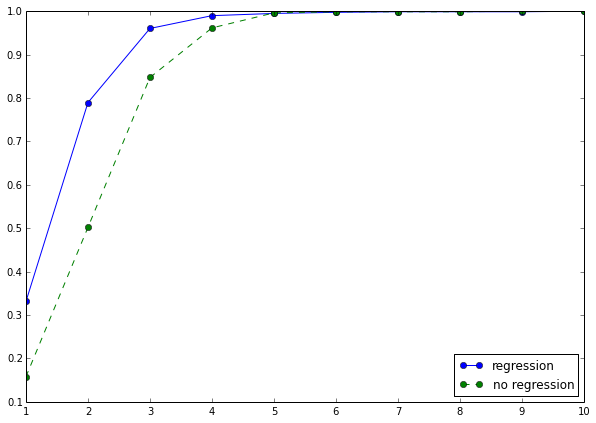

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,11), within_after, marker="o", label = "regression")
plt.errorbar(range(1,11), within_before, linestyle="--", marker="o", label="no regression")

plt.legend(loc='lower right')
plt.show()